In [1]:
%matplotlib inline
import sys

from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing, TimeSeries
from u8timeseries.metrics import mape
from u8timeseries.backtesting import get_train_val_series, backtest_autoregressive_model

import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

## Read data

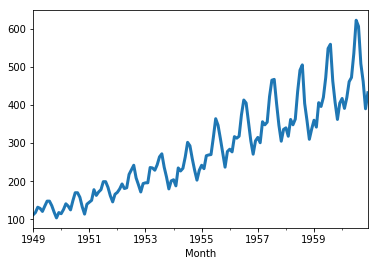

In [2]:
df = pd.read_csv('AirPassengers.csv')
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
series.pd_series().plot(lw=3)

## Build three models

In [3]:
model_es = ExponentialSmoothing()
model_pr = Prophet()
model_bl = KthValueAgoBaseline(K=1)

## Try one of the models

In [9]:
train, val = series.split_after(pd.Timestamp('19570101'))
model_pr.fit(train)
pred = model_pr.predict(len(val))

/Users/julien/anaconda3/envs/timeseries/lib/python3.6/site-packages/fbprophet/forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


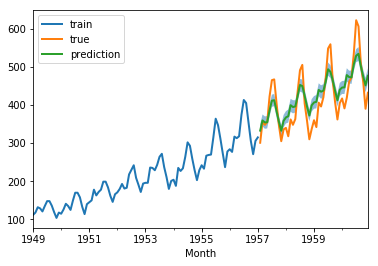

In [8]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()

## Backtest the models on the data
Simulate 12-months ahead predictions done in the past, starting in January 1955.

In [10]:
def backtest_model(model):
    tic = time.time()
    train_val_series = get_train_val_series(series, start=pd.Timestamp('19550101'), nr_points_in_val=12)
    res = backtest_autoregressive_model(model, train_val_series, mape)
    tac = time.time()
    print('Backtest done in %.2f s.' % (tac-tic))
    return res

In [11]:
res_es = backtest_model(model_es)
res_pr = backtest_model(model_pr)
res_bl = backtest_model(model_bl)

Backtest done in 60.23 s.
Backtest done in 122.64 s.
Backtest done in 0.58 s.


## Plot backtesting results

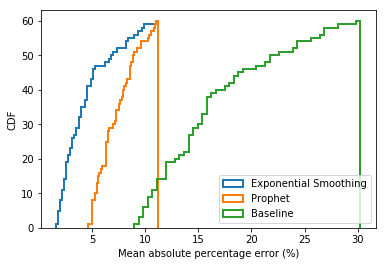

In [12]:
plt.hist(res_es, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Exponential Smoothing');
plt.hist(res_pr, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Prophet');
plt.hist(res_bl, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Baseline');

plt.xlabel('Mean absolute percentage error (%)')
plt.ylabel('CDF')
plt.legend(loc=4)

## Let's make an actual forecast!
Since Exponential Smoothing is better in backtests, let's use this one.

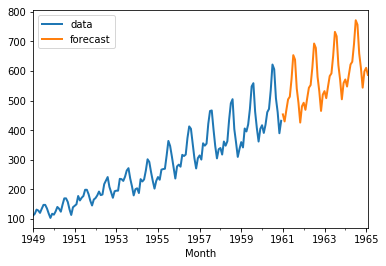

In [13]:
model_es.fit(series)
pred = model_es.predict(n = 50)

series.pd_series().plot(label='data', lw=2)
pred.pd_series().plot(label='forecast', lw=2)
plt.legend()

## Example of forecasting using a supervised model and extra features
Here we show how to forecast with a supervised model, with an additional dummy (constant) feature. Note that in this case the resulting forecasts are not so interesting, as random forest simply predicts the last value because our extra feature is not informative.

In [ ]:
df_with_feature = df.copy()
df_with_feature['dummy_feature'] = [1 for _ in range(len(df))]

model_rf.fit(df_with_feature, '#Passengers', 'Month', 'month', feature_columns=['dummy_feature'])

# Predict for three years
test_dates = [datetime(1961, m, 1) for m in range(1, 13)] + \
             [datetime(1962, m, 1) for m in range(1, 13)] + \
             [datetime(1963, m, 1) for m in range(1, 13)]

test_df = pd.DataFrame({'Month': test_dates})
test_df['dummy_feature'] = [1 for _ in range(len(test_df))]

predicted_df = model_rf.predict(test_df)

plt.figure()
plt.plot(df['Month'], df['#Passengers'])
plt.plot(predicted_df['Month'], predicted_df['yhat'])